In [ ]:
# https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

# http://dcase.community/documents/workshop2020/proceedings/DCASE2020Workshop_Perez-Castanos_15.pdf
# normalise les données ( normalization of zero mean and standard deviation of one is performed for each frequen)

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

from joblib import dump, load

%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
def loadMatrixDataframes(machines, sets):
  dataFolder = '/drive/MyDrive/asdpy/data/original/dc2020task2'
  matrix = []
  anomalies = []

  for machine in machines:
      for s in sets:
          saveName = dataFolder+'/'+machine+'/df_matrices_'+machine+'_'+s+'.joblib'
          matrix_partial = load(saveName)
          #print(type(matrix_partial)) # <class 'numpy.ndarray'>
          #print(matrix_partial.shape)

          # reshape images
          matrix_partial = np.reshape(matrix_partial, (len(matrix_partial), 313, 128, 1))

          # remove last column so columns number is divisible by 4
          matrix_partial = np.delete(matrix_partial, np.s_[-1:], axis=1)

          # add to matrix list
          matrix.append(matrix_partial)
          #print(type(matrix)) # <class 'list'>
          #print(matrix_partial)
          #print("======")

          saveName = dataFolder+'/'+machine+'/df_matrices_anomalies_'+machine+'_'+s+'.joblib'
          anomalies_partial = load(saveName)
          anomalies.append(anomalies_partial)

  # concatenate all partials dataframes on horizontal axis
  return np.concatenate(matrix, axis=0), np.concatenate(anomalies, axis=0)

In [ ]:
# transform the matrices in vectors
def toVector(matrix):
  return np.reshape(matrix, (len(matrix), 312*128))

# transform the vectors in machines
def toMatrix(vector):
  return np.reshape(vector, (len(vector), 312, 128, 1))

def normalize(scaler, matrix):
  return matrix
  vector = toVector(matrix)
  vector_scaled = scaler.transform(vector)
  matrix_scaled = toMatrix(vector_scaled)
  return matrix_scaled

def unnormalize(scaler, matrix_scaled):
  return matrix_scaled
  vector_scaled = toVector(matrix_scaled)
  vector = scaler.inverse_transform(vector_scaled)
  matrix = toMatrix(vector)
  return matrix


In [ ]:
# load training datas
machines = ['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

# concatenate all dataframes as one
matrix, anomalies = loadMatrixDataframes(['fan', 'pump', 'slider', 'valve'], ['train'])

#print(matrix)
print(matrix.shape)
#print(matrix.dtypes)

print(anomalies)
print(anomalies.shape)
#print(anomalies.dtypes)

# normalize matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(toVector(matrix))
matrix_scaled = normalize(scaler, matrix)

# split for training
from sklearn.model_selection import train_test_split
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(matrix_scaled, anomalies, test_size=0.33, random_state=42)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

# spare RAM
del matrix
del matrix_scaled

(13119, 312, 128, 1)
[0 0 0 ... 0 0 0]
(13119,)
(8789, 312, 128, 1)
(4330, 312, 128, 1)


In [ ]:
# Create the Encoder and Decoder
#pass the gray scale input image of size(128,313,1)
inputs = tf.keras.Input(shape=(312, 128, 1), name='input_layer')
#inputs = tf.keras.Input(shape=(40064, 1, 1), name='input_layer')

# strides: va diviser les dimensions de l'image par la valeur

strides_1 = 4;
strides_2 = 2;

# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)

# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=strides_1, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)

# Conv Block 3 -> BatchNorm->leaky Relu
#encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=strides_2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides=strides_2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides=1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)

# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides=strides_2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)

# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, strides=strides_1, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

# output
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [ ]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))
  #return tf.math.reduce_euclidean_norm(tf.image.ssim(y_true, y_pred,1.0)) # n'importe quoi
  

In [ ]:
model = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(optimizer=optimizer, loss=SSIMLoss)
#model.compile(optimizer=optimizer, loss='mean_squared_error') # n'importe quoi

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 312, 128, 1)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 312, 128, 32)      320       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 312, 128, 32)      128       
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 312, 128, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 78, 32, 64)        18496     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 78, 32, 64)        256       
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 78, 32, 64)        0     

In [ ]:
# sans CPU : 
# avec TPU : modif particulière requise
# avec GPU : 12 secondes par epoch
# 25 epochs : val_loss: 0.45
# 50 epochs : val_loss: 0.12
# 75 epochs : val_loss: 0.106
# 100 epochs : val_loss: 0.093
hist=model.fit(X_train_scaled, X_train_scaled,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled)
                )

Epoch 1/20
69/69 [==============================] - 77s 654ms/step - loss: 0.5294 - val_loss: 0.7204
Epoch 2/20
69/69 [==============================] - 42s 614ms/step - loss: 0.3156 - val_loss: 0.6866
Epoch 3/20
69/69 [==============================] - 38s 555ms/step - loss: 0.2572 - val_loss: 0.6222
Epoch 4/20
69/69 [==============================] - 42s 613ms/step - loss: 0.2260 - val_loss: 0.5341
Epoch 5/20
69/69 [==============================] - 38s 555ms/step - loss: 0.2068 - val_loss: 0.4369
Epoch 6/20
69/69 [==============================] - 38s 556ms/step - loss: 0.1938 - val_loss: 0.3475
Epoch 7/20
69/69 [==============================] - 38s 555ms/step - loss: 0.1839 - val_loss: 0.2784
Epoch 8/20
69/69 [==============================] - 38s 555ms/step - loss: 0.1754 - val_loss: 0.2256
Epoch 9/20
69/69 [==============================] - 38s 554ms/step - loss: 0.1680 - val_loss: 0.1954
Epoch 10/20
69/69 [==============================] - 42s 613ms/step - loss: 0.1615 - val_lo

In [ ]:
# save model
import pickle

dataFolder = '/drive/MyDrive/asdpy/data/tests/auto_encoder_2'
saveName = dataFolder+'/hist.pickle'
print(saveName)

with open(saveName, 'wb') as f:
    pickle.dump(hist.history, f)
    

/drive/MyDrive/asdpy/data/tests/auto_encoder_2/hist.pickle


In [ ]:
import random

# function for result display
def show_spectrograms(original, reconstructed, anomalies, n):  

  plt.figure(figsize=(14, 7), dpi=100)
  plt.subplots_adjust( wspace=0.1, hspace=0.07)
  plt_a=1

  for i in range(n):
      j = random.randrange(len(original))

      # Original training dataset vs Original training
      ax = plt.subplot(3, n, plt_a   )
      plt.imshow(original[j].reshape(312, 128).T)
      plt.gray()
      ax.get_xaxis().set_visible(True)
      ax.get_yaxis().set_visible(False)
      ax.set_title("Original")
      
      # Reconstructed good data  vs Original training data
      ax = plt.subplot(3, n, plt_a + n )
      plt.imshow(reconstructed[j].reshape(312, 128).T)
      plt.gray()
      ax.get_xaxis().set_visible(True)
      ax.get_yaxis().set_visible(False)    
      value = SSIMLoss(reconstructed[j], original[j])
      label = 'SSIM Loss value: {:.3f}'
      ax.set_xlabel(label.format(value) )

      if anomalies[j]:
        title = "Anomaly"
      else:
        title = "Normal"

      ax.set_title(title)
      ax.set_xlabel(label.format(value))
      
      plt_a+=1

  plt.show()

In [ ]:
# encode/decode test set
y_test_pred_scaled = model.predict(X_test_scaled)

# unscale image
y_test_pred = unnormalize(scaler, y_test_pred_scaled)

In [ ]:
# load validation datas
machines = ['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

# concatenate all dataframes as one
X_validation, y_validation = loadMatrixDataframes(['fan'], ['test'])

print(X_validation.shape)
#print(matrix.dtypes)

# normalize matrix
X_validation_scaled = normalize(scaler, X_validation)

print(y_validation)
print(y_validation.shape)

# encode/decode validation set
y_validation_pred_scaled = model.predict(X_validation_scaled)

# unnormalize image
y_validation_pred = unnormalize(scaler, y_validation_pred_scaled)

(1875, 312, 128, 1)
[0 0 0 ... 0 0 0]
(1875,)


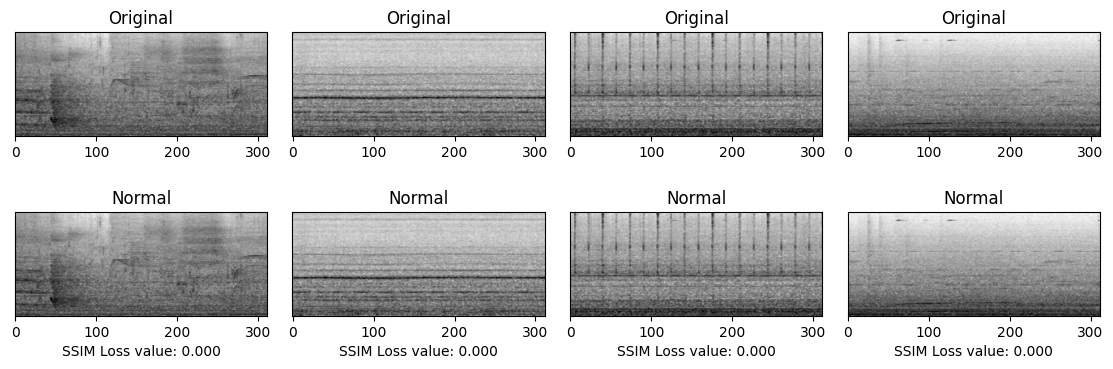

In [ ]:
# 1) same normal image
X_test_unscaled = normalize(scaler, X_test_scaled)

# reconstucted image is an exact copy of the original: SSIM Loss is null
show_spectrograms(X_test_unscaled, X_test_unscaled, y_test, 4)

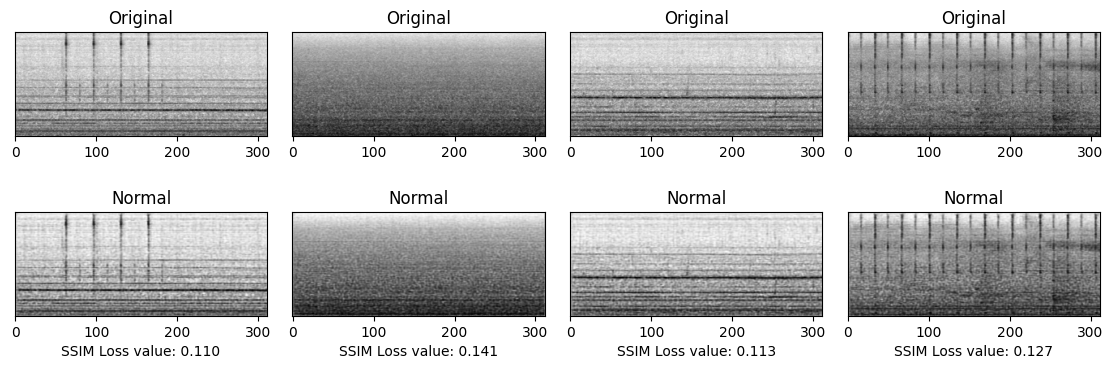

In [ ]:
# 2) top is original image, bottom is image reconstructed by autoencoder (test set, normal sounds) 
show_spectrograms(X_test_unscaled, y_test_pred, y_test, 4)

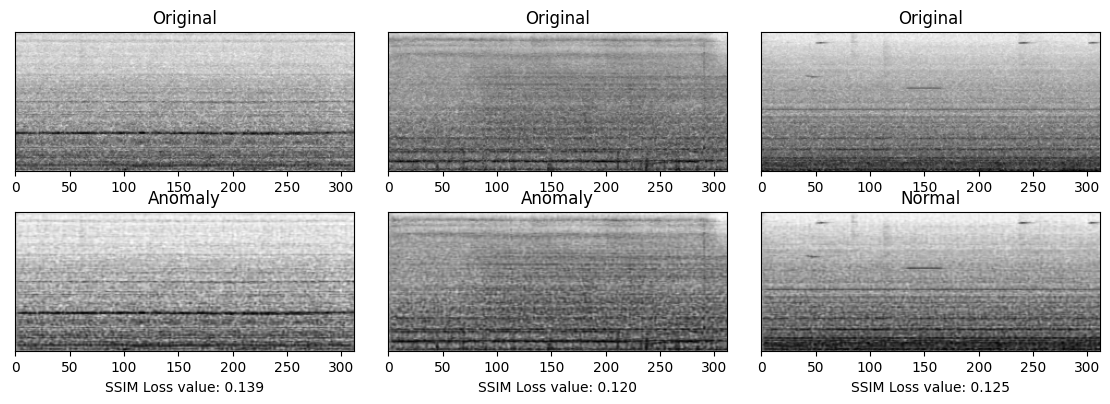

In [ ]:
# 2) top is original image, bottom is image reconstructed by autoencoder (validation set, normal and anomalous sounds) 
show_spectrograms(X_validation, y_validation_pred, y_validation, 3)